# Question 8 of HW2
### Amirhosein Pourdavoud (810101120)

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

## Load Dataset

In [190]:
from sklearn import cluster, datasets, mixture
noisy_moons = datasets.make_moons(n_samples=500, noise=0.11)

In [191]:
data = noisy_moons[0]
labels = noisy_moons[1]

data_1 = np.array([data[ind, :] for ind, l in enumerate(labels) if l==0])
data_2 = np.array([data[ind, :] for ind, l in enumerate(labels) if l==1])

## Plot data

Text(0.5, 1.0, 'noisy moon')

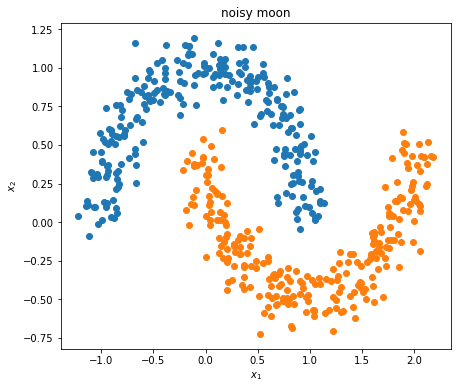

In [192]:
plt.figure(figsize=(7, 6))
plt.scatter(data_1[:, 0], data_1[:, 1])
plt.scatter(data_2[:, 0], data_2[:, 1])
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('noisy moon')

## Normal distribution

In [193]:
n_1 = data_1.shape[0]
n_2 = data_2.shape[0]
# mean of each class
mu_1 = np.mean(data_1, axis=0)
mu_2 = np.mean(data_2, axis=0)
# covariance of each class
cov_1 = np.cov(data_1.T)
cov_2 = np.cov(data_2.T)

In [194]:
x = np.linspace(-1.5, 2.5, 1000)
y = np.linspace(-1, 1.5, 1000)
x_grid, y_grid = np.meshgrid(x, y)
coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

# make gaussian distribution
dist_1 = multivariate_normal(mu_1, cov_1).pdf(coordinates).reshape(x_grid.shape)
dist_2 = multivariate_normal(mu_2, cov_2).pdf(coordinates).reshape(x_grid.shape)

### Plot distribution

Text(0.5, 1.0, 'noisy moons with estimated normal dist.')

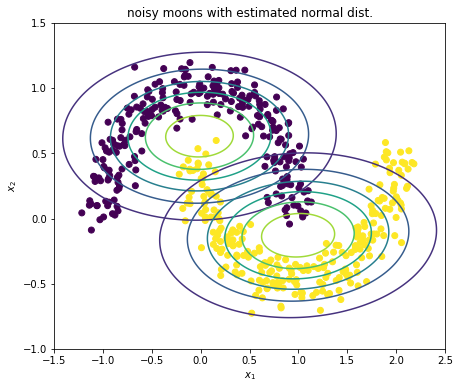

In [195]:
plt.figure(figsize=(7, 6))
plt.scatter(data[:,0], data[:,1], c=labels, cmap='viridis')
plt.contour(x_grid, y_grid, dist_1)
plt.contour(x_grid, y_grid, dist_2)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.title('noisy moons with estimated normal dist.')

## Gaussian mixture model

In [196]:
class GMM_EM(object):
    
    def __init__(self, n_components = 3, max_iter = 1e+3, tol = 1e-4):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.means_ = None
        self.covariances_ = None
        self.log_likelihoods = None
        
    def fit(self, X):
        # gaussian pdf
        guass_PDF = lambda mean ,cov: multivariate_normal.pdf(X, mean=mean, cov=cov)

        n,d = X.shape
        k = self.n_components
        
        # Initialization
        mu = X[np.random.choice(n, k, replace = False)] # mean  
        Sigma = [np.eye(d)*0.99] * k # covariance
        pi = np.array([1 / k] * k) # prior probability
        W = np.zeros((n, k)) # responsibility matrix
        log_likelihoods = [] # log-likelihoods
        
        # EM iterations
        while len(log_likelihoods) < self.max_iter:
            
            # E step
            for j in range(k):
                W[:, j] = pi[j] * guass_PDF(mu[j], Sigma[j])
            l = np.sum(np.log(np.sum(W, axis = 1)))
            log_likelihoods.append(l)
            W = (W.T / W.sum(axis = 1)).T
            W_s = np.sum(W, axis = 0)

            # M step
            for j in range(k):
                mu[j] = (1. / W_s[j]) * np.sum(W[:, j] * X.T, axis = 1).T 
                Sigma[j] = ((W[:,j] * ((X - mu[j]).T)) @ (X - mu[j])) / W_s[j]
                pi[j] = W_s[j] / n

            # check for convergence
            if len(log_likelihoods) < 2:
                continue
            if np.abs(l - log_likelihoods[-2]) < self.tol:
                break
        
        # update parameters
        self.means_ = mu
        self.covariances_ = Sigma
        self.log_likelihoods = log_likelihoods

    def aic(self, X):
        n, d = X.shape
        p = self.n_components * (d + d**2)
        return -2 * self.log_likelihoods[-1] + 2 * p
    
    def bic(self, X):
        n, d = X.shape
        p = self.n_components * (d + d**2)
        return -2 * self.log_likelihoods[-1] + np.log(n) * p

### Fit model

In [197]:
gmm_1 = []
gmm_2 = []
criterion_1 = []
criterion_2 = []

for cmpnt in range(1, 17):
    gmm_obj_1 = GMM_EM(n_components=cmpnt)
    gmm_obj_1.fit(data_1)
    gmm_1.append(gmm_obj_1)
    criterion_1.append((gmm_obj_1.aic(data_1), gmm_obj_1.bic(data_1)))

    gmm_obj_2 = GMM_EM(n_components=cmpnt)
    gmm_obj_2.fit(data_2)
    gmm_2.append(gmm_obj_2)
    criterion_2.append((gmm_obj_2.aic(data_2), gmm_obj_2.bic(data_2)))

### Plot Distribution

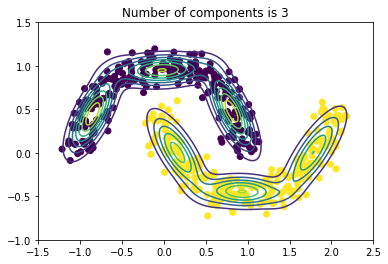

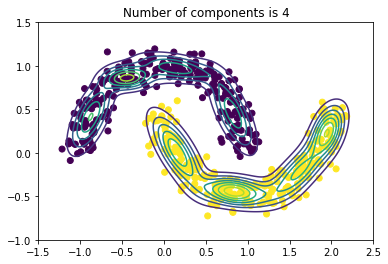

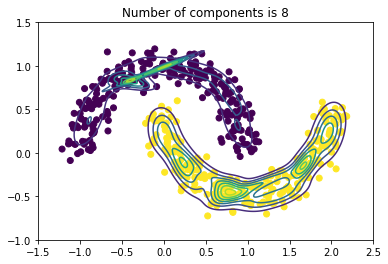

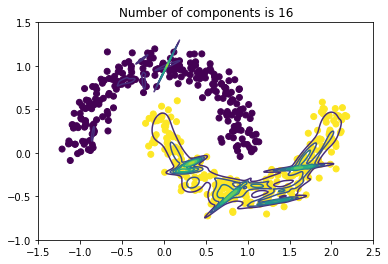

In [204]:
dist_1 = np.zeros(x_grid.shape)
dist_2 = np.zeros(x_grid.shape)

for j in [2, 3, 7, 15]:
    
    for i in range(0, gmm_1[j].means_.shape[0]):
            mean = gmm_1[j].means_[i]
            cov = gmm_1[j].covariances_[i]
            dist_1 += multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)

    for i in range(0, gmm_2[j].means_.shape[0]):
            mean = gmm_2[j].means_[i]
            cov = gmm_2[j].covariances_[i]
            dist_2 += multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
            
    plt.figure()
    plt.scatter(data[:,0], data[:,1], c=labels, cmap='viridis')
    plt.contour(x_grid, y_grid, dist_1)
    plt.contour(x_grid, y_grid, dist_2)
    plt.title('Number of components is %d'%(j+1))
    plt.show()

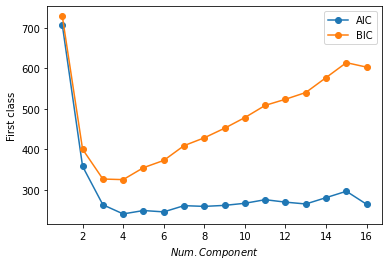

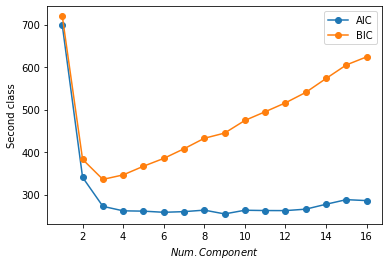

In [199]:
plt.plot(range(1, 17), criterion_1, 'o-', label=('AIC', 'BIC'))
plt.xlabel("$Num. Component$"); plt.ylabel("First class")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, 17), criterion_2, 'o-', label=('AIC', 'BIC'))
plt.xlabel("$Num. Component$"); plt.ylabel("Second class")
plt.legend()
plt.show()